In [3]:
import sys
sys.path.append('../')

In [53]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

In [5]:
from utils.data_loaders import load_clc_db_records
from utils.features import construct_features_batch
from utils.data_handling import merge_asset_data, split_by_date
from utils.loss_functions import return_loss, sharpe_loss, return_loss_dummy, sharpe_loss_dummy

In [6]:
config = tf.ConfigProto(device_count = {'GPU': 1 , 'CPU': 8}) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [7]:
RAD_DATA_PATH = '../data/clc/rad/'
FED_DATA_PATH = '../data/DFF.csv'

In [8]:
clc = load_clc_db_records(RAD_DATA_PATH, FED_DATA_PATH)

In [9]:
assets_to_use = ['AN', 'BN', 'CC', 'CN', 'CT', 'DT', 'DX', 'EC', 'FB', 'FF', 'FN',
       'FX', 'GI', 'GS', 'JN', 'JO', 'KC', 'KW', 'LB', 'LX', 'MD', 'MW',
       'NK', 'NR', 'PA', 'SB', 'SN', 'SP', 'SS', 'TU', 'TY', 'US', 'W',
       'ZA', 'ZB', 'ZC', 'ZF', 'ZG', 'ZH', 'ZI', 'ZK', 'ZL', 'ZM', 'ZN',
       'ZO', 'ZP', 'ZR', 'ZS', 'ZT', 'ZU', 'ZW', 'ZZ']
exclude_assets = ['FF', 'EC', 'TU', 'SS']
assets_to_use = list(set(assets_to_use) - set(exclude_assets))

temp_clc = {}
for asset, df in clc.items():
    if asset in assets_to_use:
        temp_clc[asset] = df
clc = temp_clc

In [10]:
clc = construct_features_batch(clc)

../utils/features.py:52: RuntimeWarning: invalid value encountered in log
  df['Sigma_Norm'] = np.log(df['Sigma'] / df['Sigma'].rolling(181).mean())


In [172]:
df = merge_asset_data(clc, create_time_asset_index=True)
df.dropna(inplace=True)

In [12]:
from datetime import datetime
# min_date = df.groupby('Asset_Col').Date_Col.min()
# max_date = df.groupby('Asset_Col').Date_Col.max()
# data_counts = df.groupby('Asset_Col').Date_Col.count()
# mask = ((max_date >= datetime(2020, 1, 1)) & (min_date <= datetime(1990, 1, 1)) & (data_counts > 4000))
# df = df[df.Asset_Col.isin(data_counts.index[mask].values)]
# df = df[df.Asset_Col == 'SP']

In [144]:
# date_breakpoints = [datetime(1990, 1, 1), datetime(1995, 1, 1), datetime(2000, 1, 1), datetime(2005, 1, 1), datetime(2010, 1, 1), datetime(2015, 1, 1), datetime(2020, 1, 1)]
date_breakpoints = [datetime(1990, 1, 1)] + [datetime(year, 1, 1) for year in range(1995, 2021)]
# date_breakpoints = [datetime(1990, 1, 1), datetime(2000, 1, 1), datetime(2005, 1, 1), datetime(2010, 1, 1), datetime(2015, 1, 1), datetime(2020, 1, 1)]
data_set = split_by_date(df, date_breakpoints)

In [171]:
df[df.Returns_Daily.isna()]

,,Open,High,Low,Settle,Volume,Open_Interest,Short_Rate_Daily,Short_Rate_Annual,Returns_Daily,Next_Returns_Daily,...,MACD_16_48,MACD_32_96,Binary_MACD_8_24,Binary_MACD_16_48,Binary_MACD_32_96,Sigma_Norm,Next_Returns_Weekly,Excess_Returns_Daily,Asset_Col,Date_Col
Asset,Date,,,,,,,,,,,,,,,,,,,,,
AN,1988-01-04,35.480000,35.480000,35.400000,35.420000,55,634,0.000280,0.0730,NaN,-0.018351,...,NaN,NaN,False,False,False,NaN,-0.016093,NaN,AN,1988-01-04
BN,1976-01-02,108.490000,108.520000,108.490000,108.520000,10,527,0.000204,0.0528,NaN,0.004700,...,NaN,NaN,False,False,False,NaN,0.003962,NaN,BN,1976-01-02
CC,1981-01-05,33637.000000,34363.000000,33637.000000,33819.000000,1108,12075,0.000704,0.1939,NaN,0.002425,...,NaN,NaN,False,False,False,NaN,-0.031225,NaN,CC,1981-01-05
CN,1978-01-03,73.202000,73.370000,73.202000,73.282000,491,1867,0.000270,0.0705,NaN,-0.003384,...,NaN,NaN,False,False,False,NaN,-0.009061,NaN,CN,1978-01-03
CT,1973-01-02,70.540000,71.070000,70.320000,70.770000,1370,12166,0.000231,0.0600,NaN,0.008337,...,NaN,NaN,False,False,False,NaN,0.052141,NaN,CT,1973-01-02
DT,1989-11-23,53.580000,53.830000,53.580000,53.800000,32850,39510,0.000319,0.0838,NaN,0.002045,...,NaN,NaN,False,False,False,NaN,-0.003532,NaN,DT,1989-11-23
DX,1986-01-02,170.326000,170.919000,169.445000,169.610000,1630,884,0.000333,0.0876,NaN,0.013484,...,NaN,NaN,False,False,False,NaN,0.001138,NaN,DX,1986-01-02
FB,1989-01-03,52.176943,52.176943,52.082853,52.091407,2773,31728,0.000357,0.0940,NaN,-0.000493,...,NaN,NaN,False,False,False,NaN,-0.002463,NaN,FB,1989-01-03
FN,1975-02-13,155.980000,155.980000,155.980000,155.980000,12,1807,0.000244,0.0633,NaN,0.011578,...,NaN,NaN,False,False,False,NaN,0.022689,NaN,FN,1975-02-13


In [145]:
data_set[0].head()

Open   High    Low  Settle  Volume  Open_Interest  \
Asset Date                                                             
AN    1990-01-02  43.46  43.51  43.30   43.30     125           2576   
      1990-01-03  43.23  43.31  43.12   43.14    1495           3232   
      1990-01-04  43.33  43.63  43.29   43.56     932           3145   
      1990-01-05  43.32  43.45  43.28   43.28     272           2567   
      1990-01-08  43.45  43.46  43.34   43.40     177           2456   

                  Short_Rate_Daily  Short_Rate_Annual  Returns_Daily  \
Asset Date                                                             
AN    1990-01-02          0.000325             0.0854      -0.007564   
      1990-01-03          0.000319             0.0837      -0.003695   
      1990-01-04          0.000316             0.0829       0.009736   
      1990-01-05          0.000313             0.0820      -0.006428   
      1990-01-08          0.000315             0.0827       0.002773   

                  Next_Returns_Daily  ...  MACD_16_48  MACD_32_96  \
Asset Date                            ...                           
AN    1990-01-02           -0.003695  ...    1.396906    1.486063   
      1990-01-03            0.009736  ...    1.305883    1.473971   
      1990-01-04           -0.006428  ...    1.298588    1.478928   
      1990-01-05            0.002773  ...    1.238528    1.472797   
      1990-01-08            0.001152  ...    1.205557    1.471873   

                  Binary_MACD_8_24  Binary_MACD_16_48  Binary_MACD_32_96  \
Asset Date                                                                 
AN    1990-01-02              True               True               True   
      1990-01-03              True               True               True   
      1990-01-04              True               True               True   
      1990-01-05              True               True               True   
      1990-01-08              True               True               True   

                  Sigma_Norm  Next_Returns_Weekly  Excess_Returns_Daily  \
Asset Date                                                                
AN    1990-01-02   -0.382612             0.003464             -0.007889   
      1990-01-03   -0.384980             0.010895             -0.004014   
      1990-01-04   -0.344513             0.006428              0.009420   
      1990-01-05   -0.328893             0.013863             -0.006741   
      1990-01-08   -0.339329             0.009447              0.002457   

                  Asset_Col   Date_Col  
Asset Date                              
AN    1990-01-02         AN 1990-01-02  
      1990-01-03         AN 1990-01-03  
      1990-01-04         AN 1990-01-04  
      1990-01-05         AN 1990-01-05  
      1990-01-08         AN 1990-01-08  

[5 rows x 27 columns]

In [147]:
epochs = 100
batch_size = 2 ** 11
feature_labels = [
   'Norm_Returns_Daily', 'Norm_Returns_Monthly', 'Norm_Returns_Quarterly',
   'Norm_Returns_Semiannually', 'Norm_Returns_Annually', 'MACD_8_24',
   'MACD_16_48', 'MACD_32_96','Sigma_Norm'
]#'Binary_MACD_8_24', 'Binary_MACD_16_48', 'Binary_MACD_32_96'
target_labels = ['Next_Returns_Daily', 'Sigma']
# feature_labels = [
#     'Norm_Returns_Monthly',
#    'Binary_MACD_8_24', 
# #     'Binary_MACD_16_48', 'Binary_MACD_32_96',
#     'Sigma_Norm'
# ]

In [164]:
def construct_mlp_model(input_shape, hidden_layers=1, hidden_neurons=5, hidden_dropout=0.2, input_dropout=0, input_activation='relu', hidden_activation='relu', **kwargs):
    hidden_layers = int(hidden_layers)
    hidden_neurons = int(hidden_neurons)
    model = Sequential()
    model.add(Dense(input_shape, activation=input_activation, kernel_initializer='normal', input_shape=(input_shape,)))
    model.add(Dropout(input_dropout))
    for _ in range(hidden_layers):
        model.add(Dense(hidden_neurons, activation=hidden_activation, kernel_initializer='normal', bias_initializer='normal'))
        model.add(Dropout(hidden_dropout))
    model.add(Dense(1, activation='tanh', kernel_initializer='normal', bias_initializer='normal'))
    return model

In [166]:
# define an objective function

# construct features and targets
data_series = data_set[0]
val_series = data_set[1]
scaler = StandardScaler()
scaler.fit(data_series[feature_labels].values)
X = scaler.transform(data_series[feature_labels].values)
X = data_series[feature_labels].values
y = data_series[target_labels].values
X_val = scaler.transform(val_series[feature_labels].values)
y_val = val_series[target_labels].values


def hyperopt_objective(args, X=X, y=y, X_val=X_val, y_val=y_val):
    
    print(args)

    # define model
    model = construct_mlp_model(**args)
    opti = optimizers.Adam(lr=args['lr'], beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss=sharpe_loss, optimizer=opti)
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
    history = model.fit(
        X, y,
        batch_size=batch_size,
        epochs=epochs,
        verbose=0,
        validation_data=(X_val, y_val),
        shuffle=False,
        callbacks=[earlyStopping]
    )
    
    return np.mean(history.history['val_loss'][2:-5])
    
# define a search space
from hyperopt import hp
activation_funcs = ['sigmoid', 'relu']
space = {
    'input_shape': len(feature_labels),
    'lr': hp.loguniform('lr', -10, 0),
    'input_activation': hp.choice('input_activation', activation_funcs),
    'hidden_activation': hp.choice('hidden_activation', activation_funcs),
    'hidden_layers': hp.quniform('hidden_layers', 1, 3, 1),
    'hidden_neurons': hp.quniform('hidden_neurons', 1, 6, 1),
    'hidden_dropout': hp.uniform('hidden_dropout', 0, 0.5),
    'input_dropout': hp.uniform('input_dropout', 0, 0.5)
}

# minimize the objective over the space
from hyperopt import fmin, tpe, space_eval
best = fmin(hyperopt_objective, space, algo=tpe.suggest, max_evals=100)

{'hidden_activation': 'relu', 'hidden_dropout': 0.2864928776096594, 'hidden_layers': 2.0, 'hidden_neurons': 5.0, 'input_activation': 'sigmoid', 'input_dropout': 0.33470791075433043, 'input_shape': 9, 'lr': 0.02728953956327466}
{'hidden_activation': 'relu', 'hidden_dropout': 0.17923231110203292, 'hidden_layers': 2.0, 'hidden_neurons': 1.0, 'input_activation': 'sigmoid', 'input_dropout': 0.4984211256821241, 'input_shape': 9, 'lr': 0.3714461165941436}
{'hidden_activation': 'sigmoid', 'hidden_dropout': 0.014183016314686214, 'hidden_layers': 1.0, 'hidden_neurons': 5.0, 'input_activation': 'sigmoid', 'input_dropout': 0.4653401963068852, 'input_shape': 9, 'lr': 0.021918383285302594}
{'hidden_activation': 'sigmoid', 'hidden_dropout': 0.2571347411379084, 'hidden_layers': 3.0, 'hidden_neurons': 5.0, 'input_activation': 'sigmoid', 'input_dropout': 0.3547503682865295, 'input_shape': 9, 'lr': 0.07794001281412882}
{'hidden_activation': 'sigmoid', 'hidden_dropout': 0.47348945668679643, 'hidden_layers

In [ ]:
-0.7389418544866572

In [59]:
best['hidden_activation'] = activation_funcs[best['hidden_activation']]
best['input_activation'] = activation_funcs[best['input_activation']]

In [167]:
best

{'hidden_activation': 1,
 'hidden_dropout': 0.17923231110203292,
 'hidden_layers': 2.0,
 'hidden_neurons': 1.0,
 'input_activation': 0,
 'input_dropout': 0.4984211256821241,
 'lr': 0.3714461165941436}

In [194]:
# model = construct_mlp_model(input_shape=len(feature_labels), **best)
model = construct_mlp_model(input_shape=len(feature_labels), hidden_layers=1, hidden_neurons=5, hidden_dropout=0.35, input_dropout=0, input_activation='relu', hidden_activation='relu')
model.summary()

# opti = optimizers.Adagrad()
# opti = optimizers.SGD(momentum=0.9, nesterov=True)
opti = optimizers.Adam(lr=0.008, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(
    loss=sharpe_loss,
    optimizer=opti
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_938 (Dense)            (None, 9)                 90        
_________________________________________________________________
dropout_699 (Dropout)        (None, 9)                 0         
_________________________________________________________________
dense_939 (Dense)            (None, 5)                 50        
_________________________________________________________________
dropout_700 (Dropout)        (None, 5)                 0         
_________________________________________________________________
dense_940 (Dense)            (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [150]:
TARGET_VOLA = 0.15

In [151]:
from datetime import timedelta


In [154]:
import numpy as np
from keras.callbacks import Callback
class GetBest(Callback):
    """Get the best model at the end of training.
	# Arguments
        monitor: quantity to monitor.
        verbose: verbosity mode, 0 or 1.
        mode: one of {auto, min, max}.
            The decision
            to overwrite the current stored weights is made
            based on either the maximization or the
            minimization of the monitored quantity. For `val_acc`,
            this should be `max`, for `val_loss` this should
            be `min`, etc. In `auto` mode, the direction is
            automatically inferred from the name of the monitored quantity.
        period: Interval (number of epochs) between checkpoints.
	# Example
		callbacks = [GetBest(monitor='val_acc', verbose=1, mode='max')]
		mode.fit(X, y, validation_data=(X_eval, Y_eval),
                 callbacks=callbacks)
    """

    def __init__(self, monitor='val_loss', verbose=0,
                 mode='auto', period=1):
        super(GetBest, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.period = period
        self.best_epochs = 0
        self.epochs_since_last_save = 0

        if mode not in ['auto', 'min', 'max']:
            warnings.warn('GetBest mode %s is unknown, '
                          'fallback to auto mode.' % (mode),
                          RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
            self.best = np.Inf
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = -np.Inf
            else:
                self.monitor_op = np.less
                self.best = np.Inf
                
    def on_train_begin(self, logs=None):
        self.best_weights = self.model.get_weights()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            #filepath = self.filepath.format(epoch=epoch + 1, **logs)
            current = logs.get(self.monitor)
            if current is None:
                warnings.warn('Can pick best model only with %s available, '
                              'skipping.' % (self.monitor), RuntimeWarning)
            else:
                if self.monitor_op(current, self.best):
                    if self.verbose > 0:
                        print('\nEpoch %05d: %s improved from %0.5f to %0.5f,'
                              ' storing weights.'
                              % (epoch + 1, self.monitor, self.best,
                                 current))
                    self.best = current
                    self.best_epochs = epoch + 1
                    self.best_weights = self.model.get_weights()
                else:
                    if self.verbose > 0:
                        print('\nEpoch %05d: %s did not improve' %
                              (epoch + 1, self.monitor))            
                    
    def on_train_end(self, logs=None):
        if self.verbose > 0:
            print('Using epoch %05d with %s: %0.5f' % (self.best_epochs, self.monitor,
                                                       self.best))
        self.model.set_weights(self.best_weights)



In [195]:
backtest_returns = []
backtest_excess_returns = []
temp_series = pd.DataFrame()
turnover = []
for data_idx, data_series in enumerate(data_set):
    
    epoch_start = data_series.Date_Col.min()
    epoch_end = data_series.Date_Col.max()
    print(epoch_start, epoch_end)

    # concat previous data
    if temp_series.shape[0] > 0:  
        data_series = pd.concat([data_series, temp_series])
    temp_series = data_series

    # no validation set --> break
    if data_idx == len(data_set) - 1: break
    backtest_data_set = data_set[data_idx + 1]
#     val_series = pd.concat(data_set[1:])
    val_series = data_series[data_series['Date_Col'] >= (epoch_end - timedelta(days=364))]
    train_series = data_series[data_series['Date_Col'] < (epoch_end - timedelta(days=364))]
    
    # construct features and targets
    scaler = StandardScaler()
    scaler.fit(train_series[feature_labels].values)
    X = scaler.transform(train_series[feature_labels].values)
    X = train_series[feature_labels].values
    y = train_series[target_labels].values
    X_val = scaler.transform(val_series[feature_labels].values)
    y_val = val_series[target_labels].values

    early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=0, mode='min')
    return_best_model = GetBest(monitor='val_loss', verbose=0, mode='max')
    mcp_save = ModelCheckpoint('../models/overnight_best_mlp_{}.hdf5'.format(epoch_start), save_best_only=True, monitor='val_loss', mode='min')
    
    history = model.fit(
        X, y,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_val, y_val),
        shuffle=False,
        callbacks=[mcp_save, early_stopping, return_best_model]
    )
    
    # backtest
    combo_strategy_returns = None
    combo_strategy_excess_returns = None
    num_assets = df.Asset_Col.nunique()
    one_period_turnover = {}
    for asset, sub_df in backtest_data_set.groupby('Asset_Col'):
        sub_df = sub_df.set_index('Date_Col', drop=False)
        signal = pd.Series(model.predict(scaler.transform(sub_df[feature_labels].values)).reshape(-1), index=sub_df['Date_Col'])
        positions = signal * TARGET_VOLA / (sub_df['Sigma'] * num_assets)
        positions = positions.shift(1)
        one_period_turnover[asset] = signal / sub_df['Sigma']
    #     positions = positions.resample('M').last()
        if combo_strategy_returns is None:
            combo_strategy_returns = positions * sub_df.Returns_Daily
            combo_strategy_excess_returns = positions * sub_df.Excess_Returns_Daily
        else:
            combo_strategy_returns += positions * sub_df.Returns_Daily
            combo_strategy_excess_returns += positions * sub_df.Excess_Returns_Daily
        combo_strategy_returns.dropna(inplace=True)
        combo_strategy_excess_returns.dropna(inplace=True)
    turnover.append(one_period_turnover)
    backtest_returns.append(combo_strategy_returns)

1990-01-02 00:00:00 1994-12-30 00:00:00
Train on 44186 samples, validate on 12018 samples
Epoch 1/100
44186/44186 [==============================] - 5s 119us/step - loss: -0.4574 - val_loss: -0.3409
Epoch 2/100
44186/44186 [==============================] - 0s 10us/step - loss: -0.7597 - val_loss: -0.4254
Epoch 3/100
44186/44186 [==============================] - 0s 10us/step - loss: -0.8990 - val_loss: -0.3421
Epoch 4/100
44186/44186 [==============================] - 0s 10us/step - loss: -0.9350 - val_loss: -0.3606
Epoch 5/100
44186/44186 [==============================] - 0s 10us/step - loss: -0.9617 - val_loss: -0.3790
Epoch 6/100
44186/44186 [==============================] - 0s 10us/step - loss: -0.8875 - val_loss: -0.3738
Epoch 7/100
44186/44186 [==============================] - 0s 10us/step - loss: -0.9587 - val_loss: -0.4091
Epoch 8/100
44186/44186 [==============================] - 0s 10us/step - loss: -0.9377 - val_loss: -0.3567
Epoch 9/100
44186/44186 [====================

In [250]:
backtest_return_series = pd.concat(backtest_returns)

In [240]:
backtest_return_series = pd.read_csv('~/Desktop/tsmom_factor_series.csv', names=['Date', 'Returns'])
backtest_return_series['Date'] = pd.to_datetime(backtest_return_series['Date'])
backtest_return_series.set_index('Date', inplace=True, drop=False)
backtest_return_series = backtest_return_series['Returns']

In [241]:
# backtest_return_series = 0.15 * backtest_return_series / backtest_return_series.shift(1).rolling(252).std()
backtest_return_series = 0.15 * backtest_return_series / (np.sqrt(252) * backtest_return_series[:252].std())

In [258]:
np.sqrt(252) * backtest_return_series.std()

0.40183991567306904

In [230]:
short_rate = pd.read_csv(FED_DATA_PATH)
short_rate['Date_Col'] = pd.to_datetime(short_rate['DATE'])
short_rate.set_index('Date_Col', inplace=True, drop=True)
daily_short_rate = (1 + short_rate['DFF'] / 100) ** (1 / 252) - 1
daily_short_rate = daily_short_rate[daily_short_rate.index.isin(backtest_return_series.index)]
backtest_excess_return_series = backtest_return_series - daily_short_rate

In [246]:
import pickle

with open('/home/maxlamberti/Desktop/turnover.pickle', 'wb') as f:
    pickle.dump(turnover, f)

In [253]:
np.sqrt(252) * backtest_return_series[:252].std()

0.025446275019082722

In [232]:
# E[Return]                        0.275164
# E[Excess Return]                 0.261058
# Std[Return]                      0.150000
# Skew[Return]                    -0.120288
# Exc.Kurtosis[Return]             4.328829
# Sharpe                           1.740385
# Max_Drawdown                    -0.213869
# Max_Drawdown_Duration (Years)    1.415638
# dtype: float64

In [243]:
calc_strategy_returns_stats(backtest_return_series, backtest_excess_return_series)

E[Return]                        0.170928
E[Excess Return]                 0.116638
Std[Return]                      0.145424
Skew[Return]                    -0.040086
Exc.Kurtosis[Return]             1.616225
Sharpe                           0.802059
Max_Drawdown                    -0.269416
Max_Drawdown_Duration (Years)    4.995885
dtype: float64

In [175]:
backtest_return_series.shape[0] / (25)

230.44

In [160]:
# TARGET_VOLA = 0.15
# norm_backtest_return_series = backtest_return_series * TARGET_VOLA / (backtest_return_series.rolling(252).std() * np.sqrt(252))

In [244]:
backtest_return_series.to_csv('~/Desktop/tsmom_factor_series_scaled.csv')

/home/maxlamberti/anaconda3/envs/AI_ENV/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


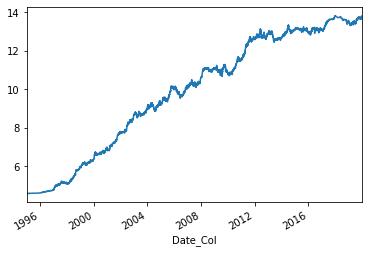

In [249]:
np.log((100 * (1 + backtest_return_series).cumprod())).plot()

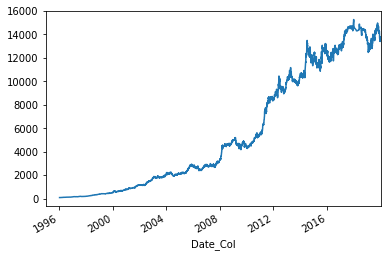

In [201]:
(100 * (1 + norm_backtest_return_series).cumprod()).plot()

In [75]:
from scipy import stats
def my_calc_single_asset_backtest(daily_return_series, excess_return_series, weights, target_vol=None):
    """Backtest a single asset trading strategy."""

    # construct backtest dataframe
    daily_return_series = daily_return_series.rename('Returns')
    weights = weights.rename('Weights')
    excess_return_series = excess_return_series.rename('Excess_Returns')
    backtest_series = pd.concat([daily_return_series, excess_return_series, weights], axis=1)
    backtest_series.Weights.ffill(inplace=True)
    backtest_series.dropna(inplace=True)
    num_data_per_year = backtest_series.Returns.resample('Y').count().mode().values[-1]
    num_data_total = backtest_series.shape[0]
    if target_vol is not None:
        backtest_series['Strategy_Returns'] = backtest_series['Weights'] * backtest_series['Returns']
        backtest_series['Weights'] = backtest_series['Weights'] * target_vol / (np.std(backtest_series['Strategy_Returns']) * np.sqrt(num_data_per_year))
    backtest_series['Strategy_Returns'] = backtest_series['Weights'] * backtest_series['Returns']
    backtest_series['Strategy_Excess_Returns'] = backtest_series['Weights'] * backtest_series['Excess_Returns']

    # basic return stats
    mean_ret_annual = ((1 + backtest_series['Strategy_Returns']).prod()) ** (num_data_per_year / num_data_total) - 1
    mean_exc_ret_annual = ((1 + backtest_series['Strategy_Excess_Returns']).prod()) ** (
            num_data_per_year / num_data_total) - 1
    vola_annual = np.std(backtest_series['Strategy_Returns']) * np.sqrt(num_data_per_year)
    sharpe = mean_exc_ret_annual / vola_annual

    # drawdown stats
    position = (1 + backtest_series['Strategy_Returns']).cumprod()
    cummax_position = position.cummax()
    drawdown = position - cummax_position
    is_in_drawdown = drawdown < 0
    longest_drawdown_duration = (~is_in_drawdown).cumsum()[is_in_drawdown].value_counts().max() / num_data_per_year
    max_drawdown = (drawdown / cummax_position).min()

    results = pd.Series({
        'E[Return]': mean_ret_annual,
        'E[Excess Return]': mean_exc_ret_annual,
        'Std[Return]': vola_annual,
        'Skew[Return]': stats.skew(backtest_series['Strategy_Returns']),
        'Exc.Kurtosis[Return]': stats.kurtosis(backtest_series['Strategy_Returns']),
        'Sharpe': sharpe,
        'Max_Drawdown': max_drawdown,
        'Max_Drawdown_Duration (Years)': longest_drawdown_duration
    })

    return results

def calc_strategy_returns_stats(daily_return_series, excess_return_series, target_vol=None):
    """Evaluate returns of a trading strategy."""

    # construct backtest dataframe
    daily_return_series = daily_return_series.rename('Strategy_Returns')
    excess_return_series = excess_return_series.rename('Strategy_Excess_Returns')
    backtest_series = pd.concat([daily_return_series, excess_return_series], axis=1)
    backtest_series.dropna(inplace=True)
    num_data_per_year = backtest_series.Strategy_Returns.resample('Y').count().mode().values[-1]
    num_data_total = backtest_series.shape[0]
    if target_vol is not None:
        vol_scaling = target_vol / (np.std(backtest_series['Strategy_Returns']) * np.sqrt(num_data_per_year))
        backtest_series['Strategy_Returns'] = vol_scaling * backtest_series['Strategy_Returns']
        backtest_series['Strategy_Excess_Returns'] = vol_scaling * backtest_series['Strategy_Excess_Returns']

    # basic return stats
    mean_ret_annual = ((1 + backtest_series['Strategy_Returns']).prod()) ** (num_data_per_year / num_data_total) - 1
    mean_exc_ret_annual = ((1 + backtest_series['Strategy_Excess_Returns']).prod()) ** (
            num_data_per_year / num_data_total) - 1
    vola_annual = np.std(backtest_series['Strategy_Returns']) * np.sqrt(num_data_per_year)
    sharpe = mean_exc_ret_annual / vola_annual

    # drawdown stats
    position = (1 + backtest_series['Strategy_Returns']).cumprod()
    cummax_position = position.cummax()
    drawdown = position - cummax_position
    is_in_drawdown = drawdown < 0
    longest_drawdown_duration = (~is_in_drawdown).cumsum()[is_in_drawdown].value_counts().max() / num_data_per_year
    max_drawdown = (drawdown / cummax_position).min()

    results = pd.Series({
        'E[Return]': mean_ret_annual,
        'E[Excess Return]': mean_exc_ret_annual,
        'Std[Return]': vola_annual,
        'Skew[Return]': stats.skew(backtest_series['Strategy_Returns']),
        'Exc.Kurtosis[Return]': stats.kurtosis(backtest_series['Strategy_Returns']),
        'Sharpe': sharpe,
        'Max_Drawdown': max_drawdown,
        'Max_Drawdown_Duration (Years)': longest_drawdown_duration
    })

    return results

In [253]:
from utils.backtest import calc_single_asset_backtest
backtest_results = {}
combo_strategy_returns = None
num_assets = df.Asset_Col.nunique()
for asset, sub_df in df.groupby('Asset_Col'):
    sub_df = sub_df.set_index('Date_Col', drop=False)
    sub_df = sub_df['1995-1-1':'2000-1-1']
    signal = pd.Series(model.predict(sub_df[feature_labels].values).reshape(-1), index=sub_df['Date_Col'])
#     signal = 0.15 * signal / signal.ewm(span=21).std()
    positions = signal * TARGET_VOLA / (sub_df['Sigma'] / num_assets)
#     positions = positions.ewm(span=7).mean()
    positions = positions.shift(1)
#     positions = positions.resample('M').last()
    if combo_strategy_returns is not None:
        combo_strategy_returns += positions * sub_df.Returns_Daily
        combo_strategy_excess_returns += positions * sub_df.Excess_Returns_Daily
    else:
        combo_strategy_returns = positions * sub_df.Returns_Daily
        combo_strategy_excess_returns = positions * sub_df.Excess_Returns_Daily
#     backtest_results[asset] = my_calc_single_asset_backtest(sub_df.Returns_Daily, sub_df.Excess_Returns_Daily, positions, 0.15)
#     positions


In [229]:
combo_strategy_returns.dropna(inplace=True)
combo_strategy_excess_returns(inplace=True)

In [236]:
calc_strategy_returns_stats(combo_strategy_returns, combo_strategy_excess_returns, target_vol=0.15)

E[Return]                        0.478098
E[Excess Return]                 0.441279
Std[Return]                      0.150000
Skew[Return]                     0.476778
Exc.Kurtosis[Return]             4.113772
Sharpe                           2.941860
Max_Drawdown                    -0.118050
Max_Drawdown_Duration (Years)    0.403292
dtype: float64

In [240]:
TARGET_VOLA = 0.15
norm_combo_strategy_returns = combo_strategy_returns * TARGET_VOLA / (np.std(combo_strategy_returns) * np.sqrt(252))

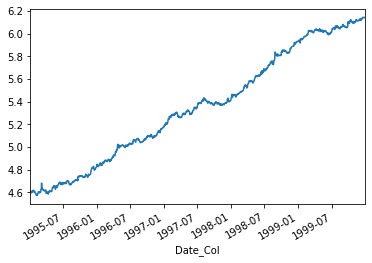

In [251]:
np.log((100 * (1 + norm_combo_strategy_returns).cumprod())).plot()

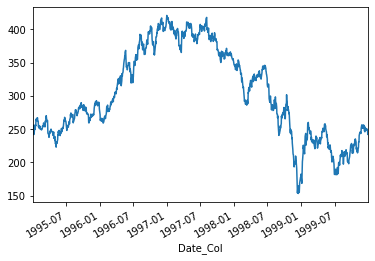

In [223]:
sub_df.Settle.plot()

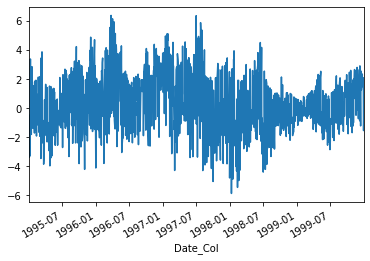

In [204]:
positions.plot()

In [205]:
backtest_df = pd.DataFrame(backtest_results).T

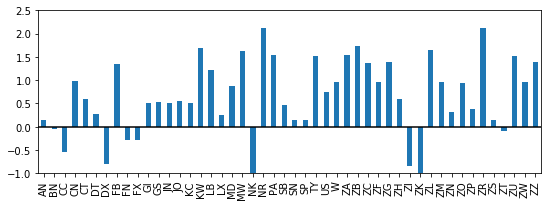

In [206]:
plt.figure(figsize=(9, 3))
backtest_df.Sharpe.plot('bar')
plt.ylim(-1, 2.5)
plt.hlines(0, -10, 90)

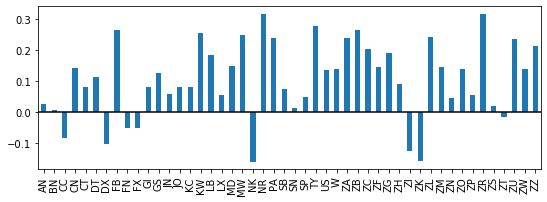

In [207]:
plt.figure(figsize=(9, 3))
backtest_df['E[Return]'].plot('bar')
# plt.ylim(-1.5, 1.5)
plt.hlines(0, -10, 90)

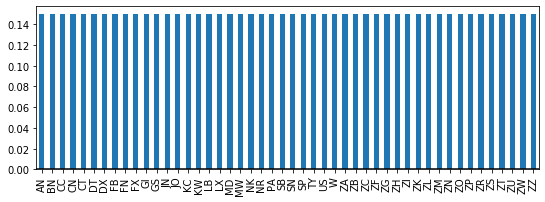

In [208]:
plt.figure(figsize=(9, 3))
backtest_df['Std[Return]'].plot('bar')
# plt.ylim(-1.5, 1.5)
plt.hlines(0, -10, 90)

In [267]:
np.random.choice(X.shape[0], 100, replace=False)

array([46176, 11656, 41925,  1100, 21945, 40042, 32517, 35676, 24429,
       42726, 24214,  4131, 25449, 48462,  2585, 30098, 38625, 43722,
       45642, 56698, 11135, 13487, 32835,   313, 27142, 31264, 17917,
       54581, 41191,  4480, 29369,  8911, 41843, 20955, 47198, 47946,
       14737, 59477, 55741, 57361, 39521, 17783, 45462, 33331, 37293,
       44070, 15907, 44985, 15491, 34009, 18047, 39155,   729, 36524,
       40104, 41269, 10259, 26060, 21101, 16209, 36371, 10524, 13078,
       41169,  7149,  9190,   740, 56910,  4242, 17017, 19491, 46105,
       36015, 19234, 57194, 26531, 14480,  9478, 39809, 44868, 54421,
       19640, 50591, 47201, 58243, 15264, 26459, 53003, 12060, 41309,
       35668, 35703, 46269, 55819, 24735, 27983, 11727, 11208, 53347,
       20828])

In [204]:
shap.initjs()

In [259]:
import shap

shap_X = pd.DataFrame(X, columns=feature_labels)
shap_X_val = pd.DataFrame(X_val, columns=feature_labels)

background = shap_X.iloc[np.random.choice(shap_X.shape[0], 1000, replace=False), :]
explainer = shap.DeepExplainer(model, background)


In [260]:
shap_values = explainer.shap_values(background.values)

# shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], background[0,:], feature_names=feature_labels)

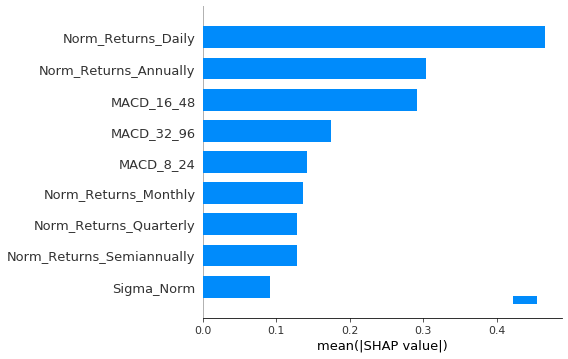

In [288]:
shap.summary_plot(shap_values, shap_X_val, class_names=' ', show=False)
plt.tight_layout()
plt.xlabel('mean(|SHAP value|)')
plt.savefig('../plots/model_shap_summary.png', dpi=350)

In [243]:
feature_labels

['Norm_Returns_Daily',
 'Norm_Returns_Monthly',
 'Norm_Returns_Quarterly',
 'Norm_Returns_Semiannually',
 'Norm_Returns_Annually',
 'MACD_8_24',
 'MACD_16_48',
 'MACD_32_96',
 'Binary_MACD_8_24',
 'Binary_MACD_16_48',
 'Binary_MACD_32_96']

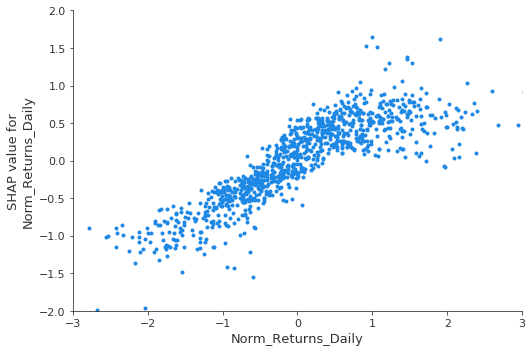

In [299]:
shap.dependence_plot('Norm_Returns_Daily', shap_values[0], background, interaction_index=None, show=False)
plt.xlim(-3, 3)
plt.ylim(-2, 2)
plt.tight_layout()
plt.savefig('../plots/shapley_daily_return_dependence.png', dpi=350)

In [69]:
preds = model.predict(X)

In [70]:
preds

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

(array([26872.,   130.,    87.,    70.,    66.,    67.,    77.,    96.,
          110., 32811.]),
 array([-0.98925346, -0.79032815, -0.59140277, -0.39247742, -0.19355208,
         0.00537327,  0.20429862,  0.40322396,  0.6021493 ,  0.8010746 ,
         1.        ], dtype=float32),
 <a list of 10 Patch objects>)

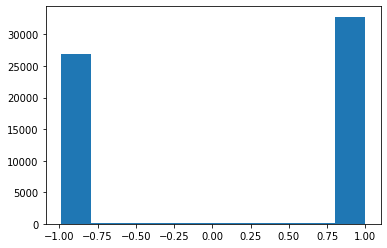

In [71]:
plt.hist(preds)

In [45]:

temp_series = pd.DataFrame()
for data_idx, data_series in enumerate(data_set):
    
    epoch_start = data_series.Date_Col.min()
    
    # no validation set --> break
    if data_idx == len(data_set) - 1: break
    val_series = data_set[data_idx + 1]
    
    # concat previous data
    if temp_series.shape[0] > 0:  
        data_series = pd.concat([data_series, temp_series])
    temp_series = data_series
    
    # construct features and targets
    X = data_series[feature_labels].values
    y = data_series[['Next_Returns_Daily', 'Sigma']].values
    X_val = val_series[feature_labels].values
    y_val = val_series[['Next_Returns_Daily', 'Sigma']].values
    
    print(X.shape, y.shape)
    print(sharpe_loss_dummy(y_val, 1.0 * np.ones(X_val.shape[0])))
    

(65394, 3) (65394, 2)
[-0.00897073  0.00345981 -0.00415321 ...  0.02146357  0.01383982
  0.00391931] [1.95528651 1.86343002 1.88443505 ... 0.70574862 0.69249298 0.6957283 ] [1. 1. 1. ... 1. 1. 1.]
-0.25967160118314275
(130484, 3) (130484, 2)
[-0.01927728  0.00071403 -0.00626512 ...  0.00305439 -0.00038654
  0.00380847] [1.24170319 1.13483732 1.15388031 ... 0.58666158 0.59634771 0.60629469] [1. 1. 1. ... 1. 1. 1.]
-0.1893210355486796
(195952, 3) (195952, 2)
[ 0.00013454  0.01030592 -0.00226621 ... -0.00767471  0.00031285
  0.00122959] [1.00995145 1.02687683 1.02537761 ... 0.79335091 0.80353713 0.81647736] [1. 1. 1. ... 1. 1. 1.]
-0.05302020570314409
(261577, 3) (261577, 2)
[-0.00267261  0.00203692 -0.0033121  ...  0.01721576 -0.00524003
  0.0017412 ] [1.79970536 1.82814296 1.84504957 ... 0.50805351 0.50892741 0.5167817 ] [1. 1. 1. ... 1. 1. 1.]
0.05248917051436436


In [134]:
df.Asset_Col.unique()

array(['AN', 'BN', 'CC', 'CN', 'CT', 'DT', 'DX', 'EC', 'FB', 'FF', 'FN',
       'FX', 'GI', 'GS', 'JN', 'JO', 'KC', 'KW', 'LB', 'LX', 'MD', 'MW',
       'NK', 'NR', 'PA', 'SB', 'SN', 'SP', 'SS', 'TU', 'TY', 'US', 'W',
       'ZA', 'ZB', 'ZC', 'ZF', 'ZG', 'ZH', 'ZI', 'ZK', 'ZL', 'ZM', 'ZN',
       'ZO', 'ZP', 'ZR', 'ZS', 'ZT', 'ZU', 'ZW', 'ZZ'], dtype=object)

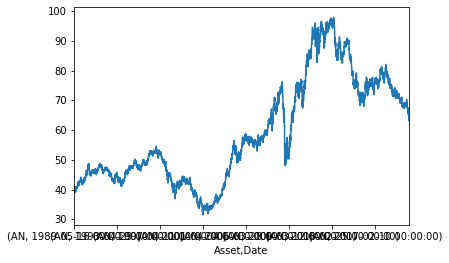

In [135]:
df[df.Asset_Col == 'AN'].Settle.plot()

In [47]:
def sharpe_loss_dummy(target_data, size_prediction, sigma_tgt=0.15):
    """Sharpe ratio inspired loss function."""

    # load parameters
    next_period_return = target_data[:, 0]
    sigma_t = target_data[:, 1]

    # calc sharpe
#     print(next_period_return, sigma_tgt / (np.sqrt(252) * sigma_t), size_prediction)
    ret = size_prediction * sigma_tgt * next_period_return / (np.sqrt(252) * sigma_t)
    mean_ret = np.mean(ret)
    mean_ret2 = np.mean(ret ** 2)
    sharpe = ((1 + mean_ret)**252 - 1) / np.sqrt(252 * (mean_ret2 - (mean_ret ** 2)))

    print(mean_ret, np.mean(size_prediction * sigma_tgt / (np.sqrt(252) * sigma_t)), np.sqrt(mean_ret2 - (mean_ret ** 2)), mean_ret2, mean_ret ** 2)
    
    return -sharpe

temp_df = data_set[1]
# temp_df = temp_df[temp_df.Asset_Col == 'SP']

print(sharpe_loss_dummy(temp_df[['Next_Returns_Daily', 'Sigma']].values, 1 * np.ones(temp_df.shape[0])))

0.00015703998295778115 5.3720792060686735 0.00979203634798409 9.590863739648897e-05 2.4661556247380194e-08
-0.25967160118314275


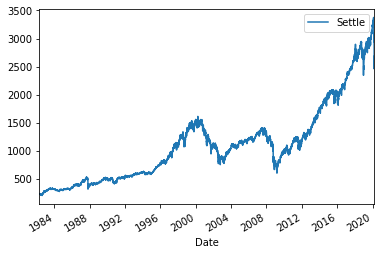

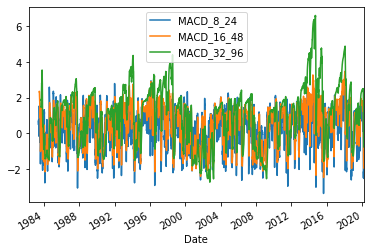

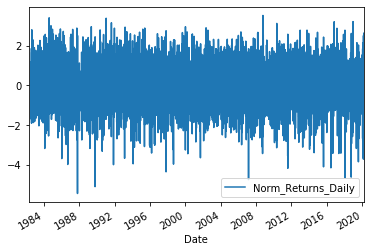

In [67]:
df.plot(x='Date', y=['Settle'])
plt.show()
df.plot(x='Date', y=['MACD_8_24', 'MACD_16_48', 'MACD_32_96'])
plt.show()
df.plot(x='Date', y=['Norm_Returns_Daily'])


In [31]:
0.007239 * np.sqrt(252)

0.11491556244477943